In [2]:
import numpy as np
import scipy
import pandas as pd
import pybedtools as pb

# figs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import seaborn as sns


#import h5py
#import allel

# my libs
import EnrichRLib as erl
import RNA_expression_processing as rn
import Enh_Mut_Manip as emm

# warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter("ignore", ResourceWarning)

In [3]:
### == Math functions == 
def log2p1(x):
    return np.log2(x + 1)

In [4]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')
WGS = join(DATADIR,'tracks/WGS-WES/Germline')
RP = join(DATADIR,'tracks/MARGE/relativeRP/bam_input')



# Data loading

### Regulatory potentials based on H3K27ac -- TLX3-vs-RAG

In [52]:
# Regulatory Potentials
rpt  =  pd.read_table(join(RP,'RAG_TLX_TAP_relativeRP_mm10mm9.txt'))

# -- transform
rpt = rpt.sort_values('lgFC_TLXvsRAG', axis=0, ascending=False)
rpt.drop_duplicates(subset='gene_name', inplace=True)


Ap,Bp = 'TLX_rel_RP','RAG_rel_RP'
cols = ['gene_name', Ap, Bp]

rp = rpt[cols]
rp = rp.set_index(keys=rp.columns[0])


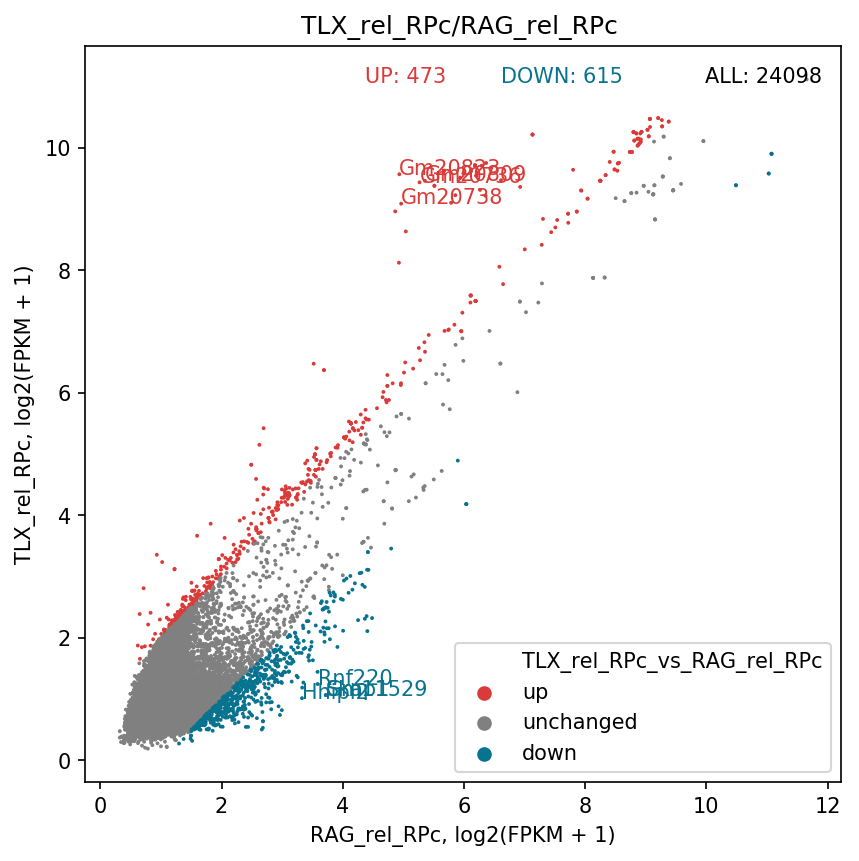

In [8]:
# classes
Ac = Ap+'c'
Bc = Bp+'c'
classe = [Ap+'c', Bp+'c']

up, dn, ax = rn.scatter_n(rp, Ac, Bc, 
                    classes=classe, 
                    n_top=4)

In [29]:
#len(up)

### RNA-expression table TLX3-vs-RAG

In [13]:
## == Expression table TLX3 vs RAG
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
expr = tbn.set_index(keys=tbn.columns[0])
#expr.index = expr.index.str.upper()

# TLX3: Story  - ZERO: 
# UP_RP(TLX3vsRAG)-->UP_Express(TLX3vsRAG)

![title](im/Prom_Story0.png)

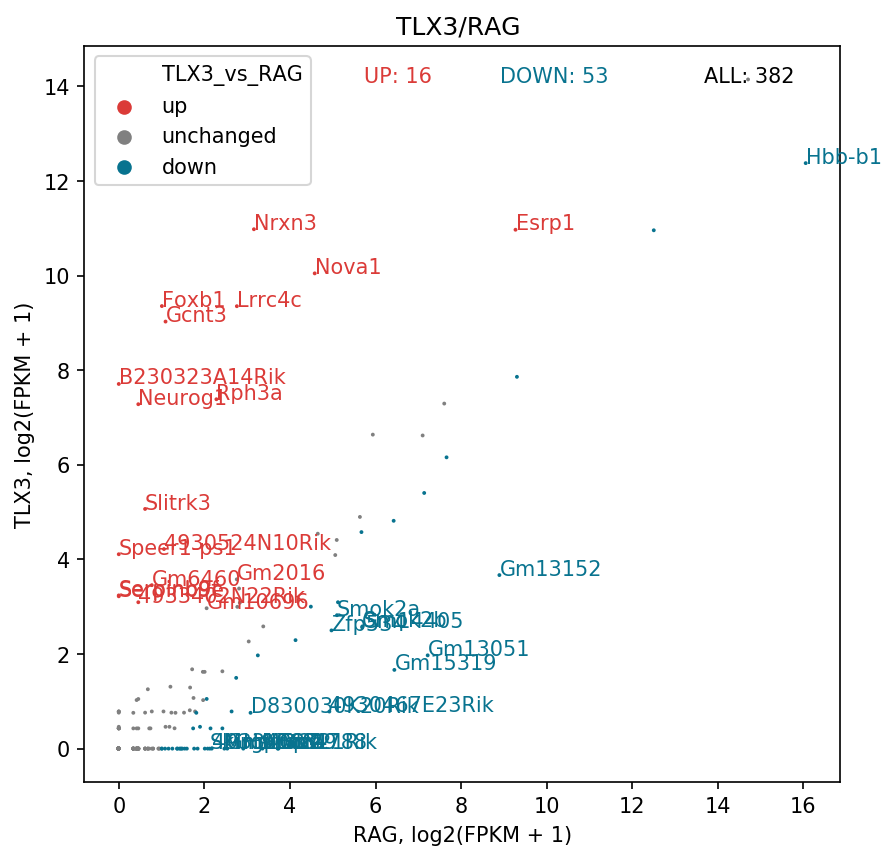

In [16]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

gl_up = list(up.index)

tmp=rn.scatter_n(expr[expr.index.isin(gl_up)], A, B,classes=classes, n_top=18)

### Enrichment

In [40]:
## Enrichment analysis
# List of gene sets 
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016',
       'Cancer_Cell_Line_Encyclopedia',
       'MSigDB_Computational',
       'MSigDB_Oncogenic_Signatures',
       'NCI-60_Cancer_Cell_Lines',
       'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
       ]

In [35]:
## Two analysis possible

#up_genes = gl_up # genes with UP H3K27ac TLX3-vs-RAG 

up_genes = list(tmp[0].index) # ONLY UPregulated genes from genes with UP H3K27ac TLX3-vs-RAG 

UP_genes = [x.upper() for x in up_genes]

enr = erl.enrich_gs(UP_genes,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 74
GO_Cellular_Component_2018 6
GO_Molecular_Function_2018 25
KEGG_2016 5
Reactome_2016 8
Cancer_Cell_Line_Encyclopedia 109
MSigDB_Computational 43
MSigDB_Oncogenic_Signatures 23
NCI-60_Cancer_Cell_Lines 13
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO 170


In [36]:
# Make additional calculation on existing columns for visualization
enr.loc[:,'ass_genes_percnt'] = 100*enr.loc[:,'num_list']/enr.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_a = enr[(enr['p-Val']<0.05)] #&(enr['ass_genes_percnt']>8)

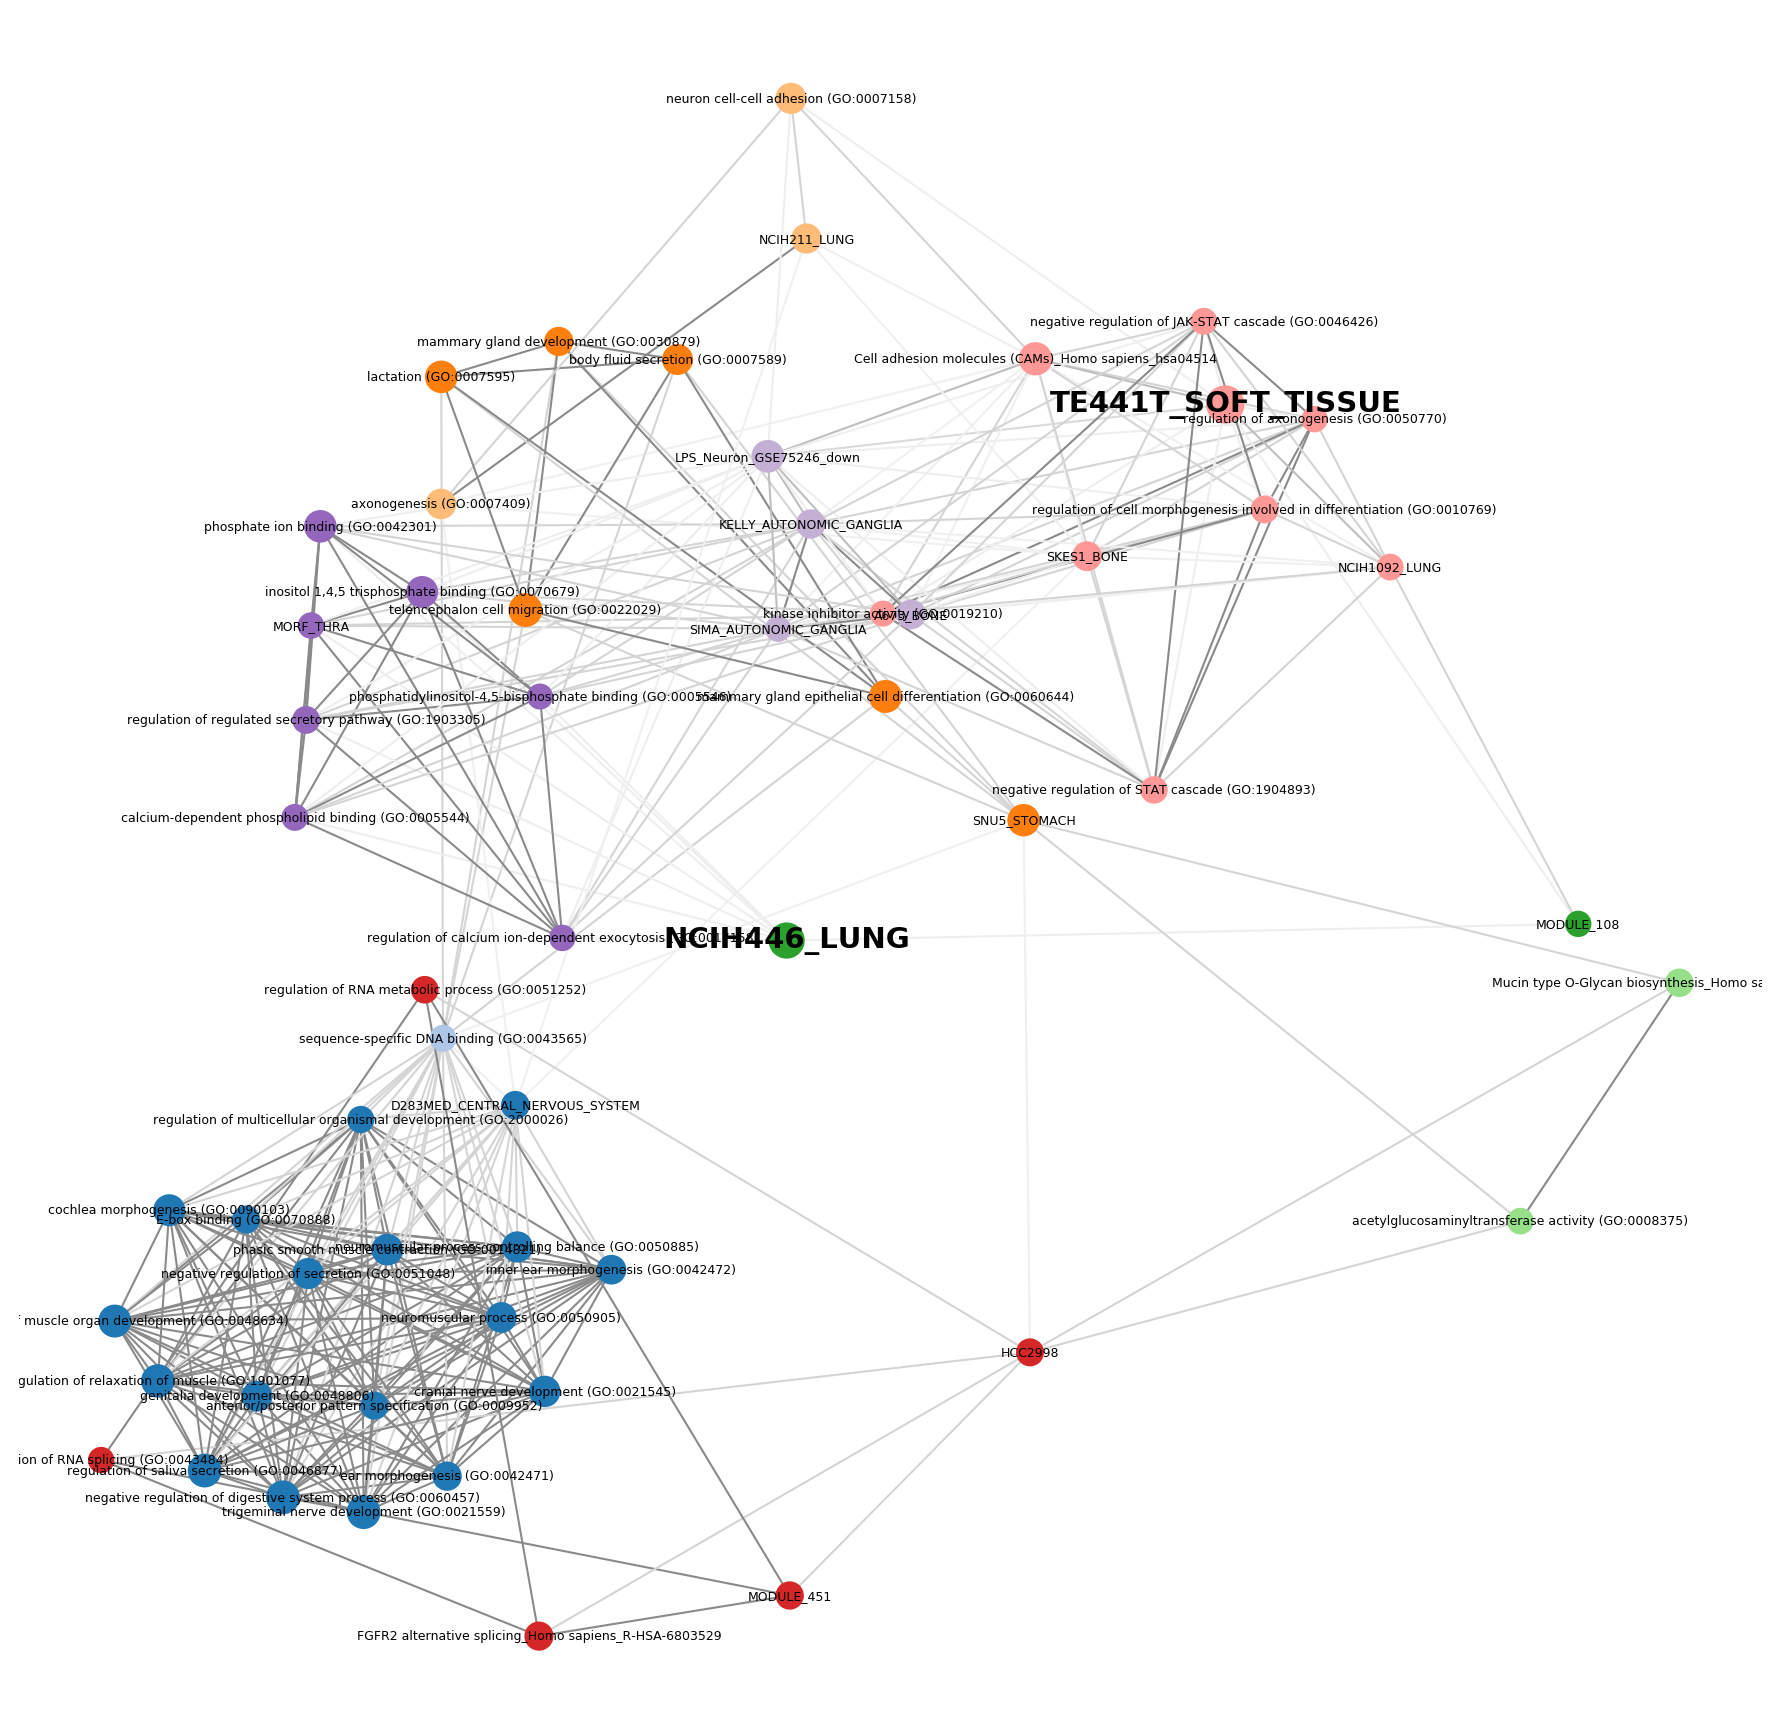

In [37]:
## Cluster: this calculate and add cluster number column
#enr_a = erl.cluster(FIN_up_genes,enr_a)
cm = 'tab20'
G, enr_c, nt_b =erl.make_graph(UP_genes, 
                                   enr_a, 
                                   kappa=0.4)
erl.draw_graph(G, 
                spring = 1.2,
                pval_prcnt=0.83,
                palette=cm)


Text(0.5,1,'UP genes regulated UP H3K27ac (TLX3/RAG) ')

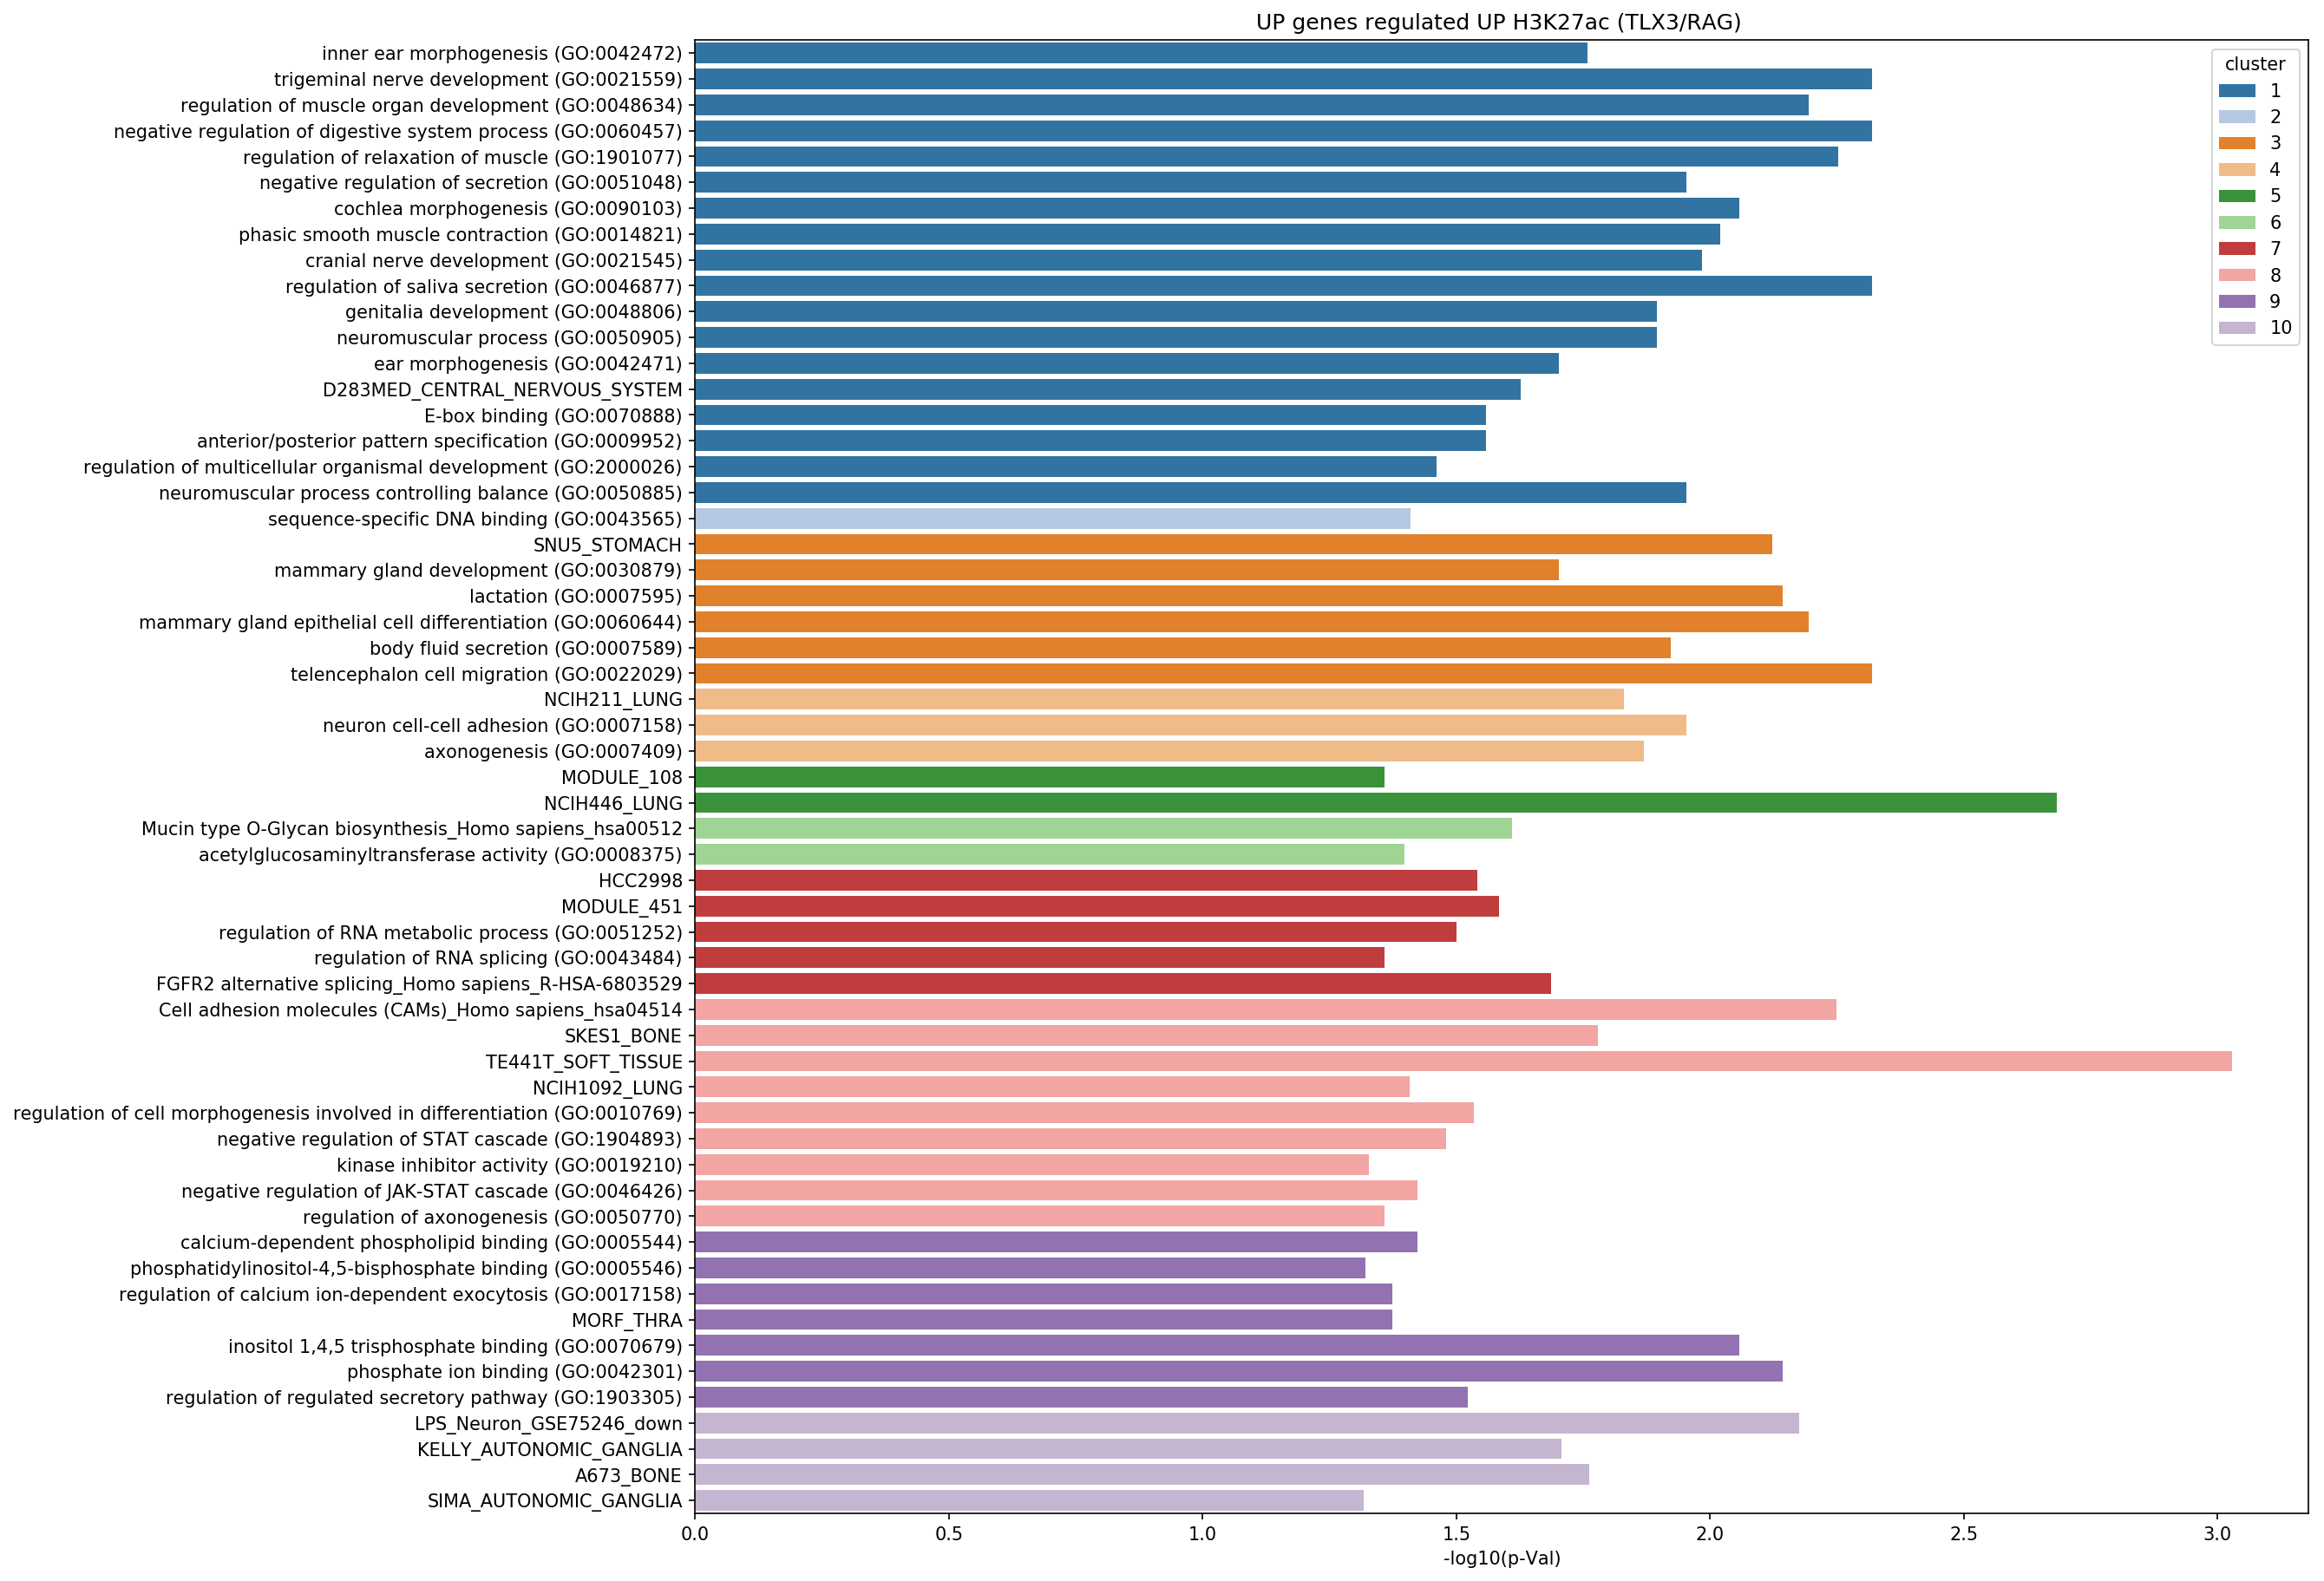

In [38]:
# --- Plot ---
# use consistent discrete palette

enr_c.sort_values('cluster', axis=0, inplace = True)
ds = enr_c.head(60)

f, ax = plt.subplots(figsize=(16, 15))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('UP genes regulated UP H3K27ac (TLX3/RAG) ')


# TLX3: Story ONE -- TLX3 peaks

![title](im/Prom_Story1.png)

In [51]:
## Load TLX peaks file
colm9 = ['chr_mm9','start_mm9','end_mm9', 'gene_name']
tlx_peak = pb.BedTool(join(DATADIR,'tracks/TLX3_TLX3_peaks.bed'))
sl = 100
tlx_peak = tlx_peak.slop(b=sl, genome='mm9')

In [54]:
### == UP analysis
tss =  3000

up_rp = rpt.loc[rpt['gene_name'].isin(list(up_genes))]
up_rp = up_rp[up_rp['end_mm9']-up_rp['start_mm9']>0]
up_rp = pb.BedTool.from_dataframe(up_rp[colm9])
up_rp = up_rp.slop(b=tss, genome='mm9')


up_rp_tlx = up_rp+tlx_peak
up_rp_gene = up_rp_tlx.to_dataframe()

upTLX_list =list(up_rp_gene['name'])
upTLX_list.sort()

In [57]:
print('Genes with UP RP and upregulated:',list(up_genes))
print('Genes with UP RP and upregulated and TLX3 peaks:',list(upTLX_list))

Genes with UP RP and upregulated: ['Foxb1', 'Gcnt3', 'Nrxn3', 'B230323A14Rik', 'Neurog1', 'Lrrc4c', 'Nova1', 'Rph3a', 'Slitrk3', 'Speer1-ps1', 'Serpinb9f', 'Serpinb9e', '4930524N10Rik', 'Gm6460', '4933402N22Rik', 'Esrp1']
Genes with UP RP and upregulated and TLX3 peaks: ['Gcnt3', 'Gm6460', 'Nrxn3']


# TLX3: Story TWO -- TLX3 mutations

![title](im/Prom_Story2.png)

In [123]:
## == Genome vcf
tlx_gn = pb.BedTool(join(WGS,'TLX3_WGS.vcf.gz'))

tss =  2000
## TSS of active promoters
up_prom = rpt.loc[rpt['gene_name'].isin(list(gl_up))]
up_prom = up_prom[up_prom['end_mm9']-up_prom['start_mm9']==1]
up_promB = pb.BedTool.from_dataframe(up_prom[colm9])
up_promB = up_promB.slop(b=tss, genome='mm9')


In [125]:
# Count variants in promoters

prom_mut_counts = emm.variants_bed_counts(tlx_gn,up_promB)
prom_mut_counts = prom_mut_counts.to_dataframe()
prom_mut_counts_srt = prom_mut_counts.sort_values('score', ascending=False)

#prom_mut_counts.head(20)

In [126]:
up_prom['mut_score'] = prom_mut_counts['score'].values

In [127]:
#up_prom.head(20)

Text(0.5,1,'Genes for UP promoters with high mutation rate')

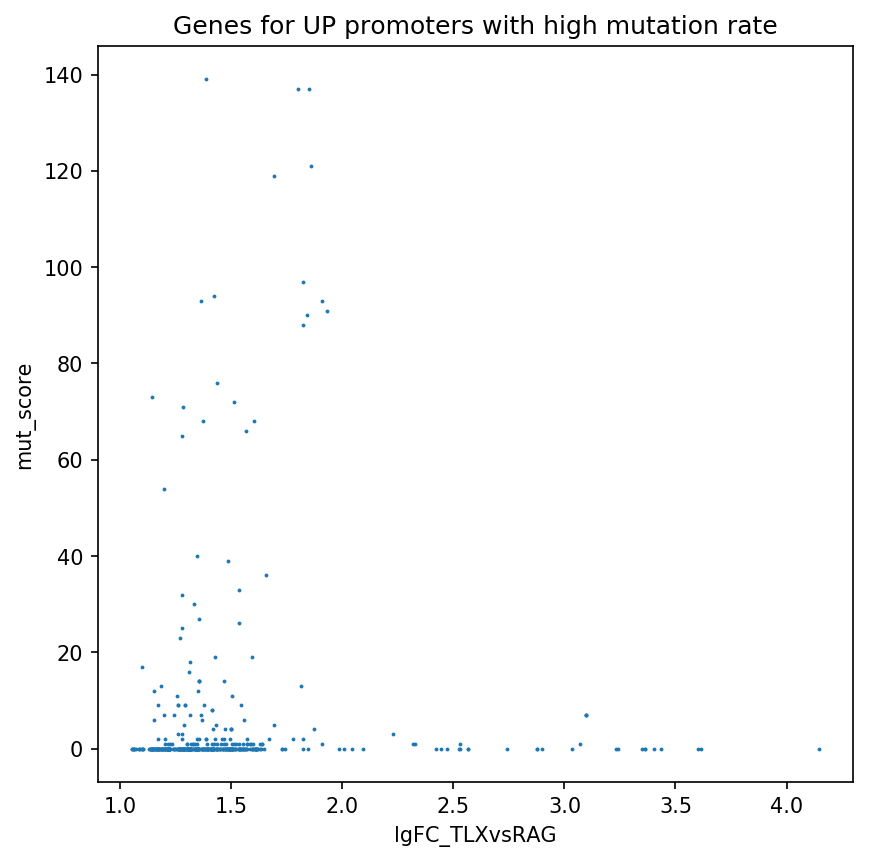

In [137]:
#cpp = {'up':(0.86, 0.23, 0.22), 'unchanged':(0.5,0.5,0.5),'down':(0.03, 0.45, 0.56)}

f1, ax1 = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x = 'lgFC_TLXvsRAG', 
                    y = 'mut_score', 
                    #hue=diff, 
                    data=up_prom, 
                    ax=ax1, 
 #                   palette=cpp, 
                    linewidth=0, 
                    s=3.4)
ax1.set_title('Genes for UP promoters with high mutation rate')

Text(0.5,1,'Genes for UP promoters with high mutation rate')

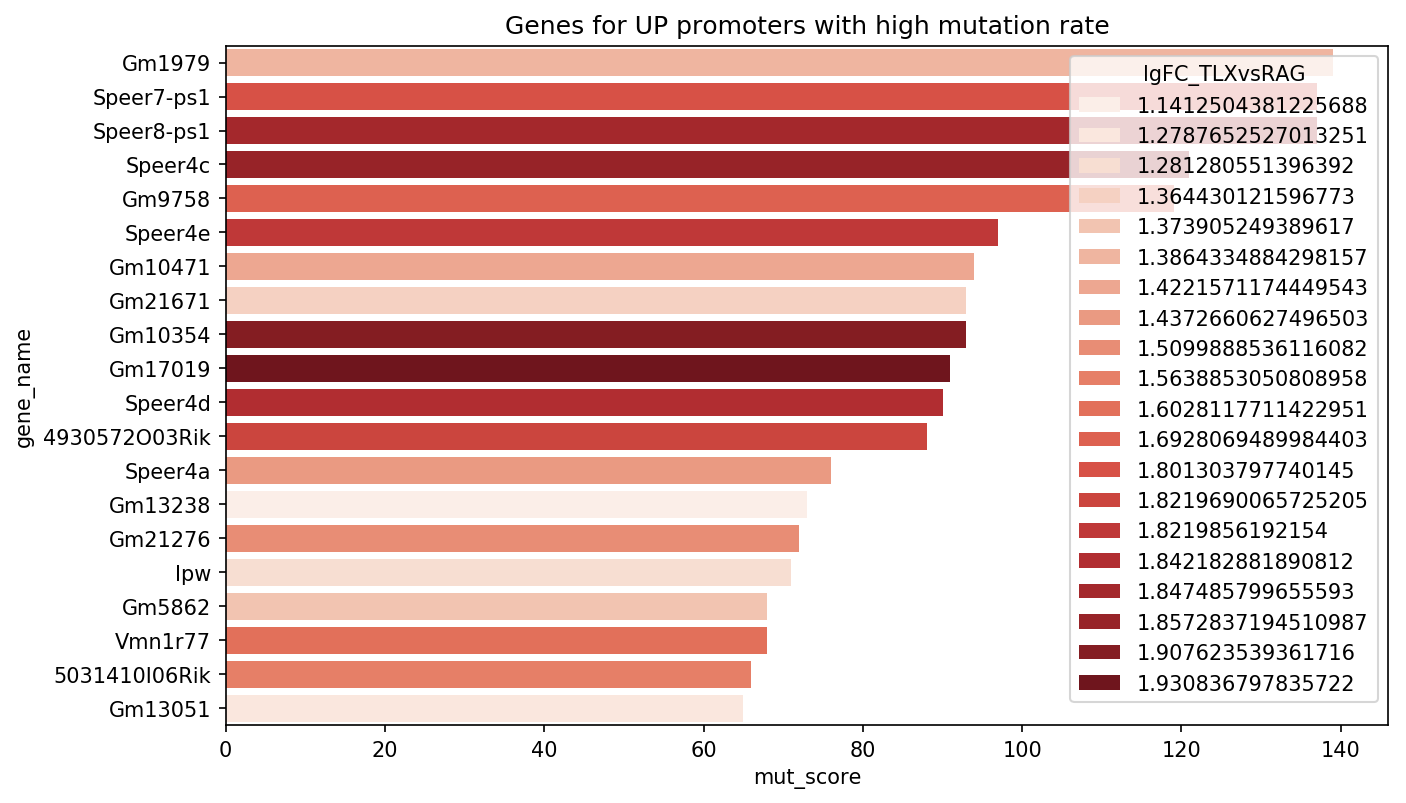

In [142]:
up_mut_rp = up_prom.sort_values('mut_score', ascending=False).head(20)#.sort_values('lgFC_TLXvsRAG', ascending=False)

cm = 'Reds'
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='gene_name',
            x='mut_score',
            ax = ax, 
            hue ='lgFC_TLXvsRAG',
            dodge=False,
            data = up_mut_rp ,
            palette = cm)
ax.set_title('Genes for UP promoters with high mutation rate')

# Motifs around mutations in active promoters

In [143]:
# Motifs models DB
db_f = '/home/sergio/tools/deepbind/db/db.tsv'

db = pd.read_csv(db_f, sep='\t',comment="#", index_col=0)
db = db[db['Labels'].isnull()]
db.drop(columns=['Class','Experiment Details','Model','Cite','Labels','Path','Comment'], inplace=True)

# Select on TFs in mouse
db_tf = db[db['Type']=='TF']
db_tf = db_tf[db_tf['Species']=='Mus musculus']

In [144]:
# Reference genome fasta
from pyfaidx import Fasta
fn = '/home/sergio/media/NAS4/PFlab/TLX3_project/WES-seq/references/mouse_mm9_reference_genome.fa'
fa = Fasta(fn)

In [146]:
# Variant inside active promoters
prom_mut_tlx = emm.bed_variants(tlx_gn,up_promB)
print('Variants from TLX3 WGS in active promoters = ', len(prom_mut_tlx))


# Save only if new analysis done
prom_mut_tlx.saveas(join(WGS,'Promoter_Active_TLX3_mut.vcf'))

# Load as table
import allel
prom_mut_tlx_tb = allel.vcf_to_dataframe(join(WGS,'Promoter_Active_TLX3_mut.vcf'),fields='*', numbers={'ALT': 4}, transformers=allel.ANNTransformer())

Variants from TLX3 WGS in active promoters =  2700


In [147]:
# mut_tb = prom_mut_tlx_tb[['CHROM', 'POS', 'REF', 'ALT_1','is_snp']]
# mut_tb = mut_tb.assign(REF_Prot="",
#                        REF_score_ref = np.nan,
#                        REF_score_alt = np.nan,
#                        REF_model = "",
#                        ALT_Prot="", 
#                        ALT_score_ref = np.nan,
#                        ALT_score_alt = np.nan,
#                        ALT_model = "")
# cols = ['CHROM', 'POS', 'REF', 'ALT_1', 'is_snp', 
#         'REF_Prot', 'REF_model', 'REF_score_ref','REF_score_alt', 
#         'ALT_Prot', 'ALT_model', 'ALT_score_ref', 'ALT_score_alt']

# mut_tb = mut_tb[cols]

# pad = 10

# # Cycling
# for i in range(len(mut_tb)):
#     var= mut_tb.loc[i]

#     ln = len(var['REF'])
#     rg = fa[var['CHROM']][int(var['POS'])-pad:int(var['POS'])+ln+pad]

#     pos = var['POS'] - rg.start
#     ref = var['REF'].upper()
#     alt = var['ALT_1'].upper()

#     fs = rg.seq.upper()
#     fm = emm.mut(fs,pos,ref,alt)

#     ### Find best model
#     dv = db_tf.copy()

#     dv['score_ref'] = list(emm.deepbind_list(list(dv.index),fs)['score'])
#     dv['score_alt'] = list(emm.deepbind_list(list(dv.index),fm)['score'])
#     dv_r = dv.sort_values('score_ref',axis=0, ascending=False)
#     dv_a = dv.sort_values('score_alt',axis=0, ascending=False)



#     mut_tb['REF_Prot'].loc[i] = dv_r.iloc[0]['Protein']
#     mut_tb['REF_score_ref'].loc[i] = dv_r.iloc[0]['score_ref']
#     mut_tb['REF_score_alt'].loc[i] = dv_r.iloc[0]['score_alt'] 
#     mut_tb['REF_model'].loc[i] = dv_r.index[0] 


#     mut_tb['ALT_Prot'].loc[i] = dv_a.iloc[0]['Protein'] 
#     mut_tb['ALT_score_ref'].loc[i] = dv_a.iloc[0]['score_ref']
#     mut_tb['ALT_score_alt'].loc[i] = dv_a.iloc[0]['score_alt']
#     mut_tb['ALT_model'].loc[i] = dv_a.index[0] 


# mut_tb.to_csv(join(WGS,'Variants_Promoter_Motifs_scores.csv'))

In [148]:
mut_tb = pd.DataFrame.from_csv(join(WGS,'Variants_Promoter_Motifs_scores.csv'))


### Select motifs with high score and ones which change TFBS
#### Sort selected motifs by score changes caused by mutation

In [150]:
mut_tb_fltr = mut_tb[(mut_tb['REF_Prot'] != mut_tb['ALT_Prot']) & (mut_tb['REF_score_ref']>2)]
mut_tb_fltr['REF_score_diff'] = mut_tb_fltr['REF_score_ref'] - mut_tb_fltr['REF_score_alt']

mut_tb_fltr_srt = mut_tb_fltr.sort_values('REF_score_diff',axis=0, ascending=False)

In [175]:
mut_tb_fltr_srt.head(10)

,CHROM,POS,REF,ALT_1,is_snp,REF_Prot,REF_model,REF_score_ref,REF_score_alt,ALT_Prot,ALT_model,ALT_score_ref,ALT_score_alt,REF_score_diff
800,chr5,14939106,G,C,True,Znf740,D00083.001,21.905510,1.496824,Sp1,D00017.001,0.467776,10.862597,20.408686
1812,chr5,26365614,T,C,True,Sox6,D00039.001,15.026183,0.266187,Snai1,D00075.001,0.798076,3.421278,14.759996
701,chr5,14915522,AGTGG,A,False,Znf740,D00083.001,19.197220,4.541955,Zfp202,D00047.001,8.622906,5.451566,14.655265
1295,chr5,15163525,G,C,True,Znf740,D00083.001,13.890070,0.129106,Egr2,D00002.001,3.718259,5.380012,13.760964
1338,chr5,15184537,A,G,True,Foxc2,D00061.001,14.455599,1.374815,Mzf1,D00028.002,4.035212,3.811571,13.080784
2374,chr7,46520378,C,T,True,Tbx20,D00042.001,12.292811,-0.025973,Pou1f1,D00070.001,0.277804,4.122620,12.318784
1294,chr5,15163521,AGTG,A,False,Znf740,D00083.001,16.829554,4.541955,Zfp202,D00047.001,10.574320,5.451566,12.287599
1811,chr5,26365613,A,G,True,Sox6,D00039.001,11.883865,0.003492,Snai1,D00075.001,0.753596,1.644030,11.880373
2110,chr5,26433337,G,T,True,Nr5a2,D00069.001,11.481431,0.099415,Esrrg,D00060.001,4.360176,1.035548,11.382016
1916,chr5,26415062,C,G,True,Znf740,D00083.001,11.180783,-0.105893,Sp1,D00017.001,0.362824,3.295820,11.286676


## Find promoters with TFS changes and associated genes

In [152]:
# Back to bed and enhancers list
mut_bd = mut_tb_fltr_srt[mut_tb_fltr_srt['REF_score_diff']>1][['CHROM','POS','REF','REF_Prot']]


mut_bd['POS_end'] = mut_bd['POS']+mut_bd['REF'].apply(len)
mut_bd = mut_bd[['CHROM','POS','POS_end', 'REF_Prot']]

mut_tf = pb.BedTool.from_dataframe(mut_bd).sort()


In [158]:
#len(up_promB)

In [157]:
mut_tf_prom = up_promB.intersect(mut_tf,wb=True).to_dataframe()
mut_tf_prom.drop(columns=['score','strand','thickStart'], inplace=True)
mut_tf_prom.rename(columns={'thickEnd':'protein'}, inplace=True)

In [161]:
mut_tf_prom_dd = mut_tf_prom.drop_duplicates()

In [166]:
print('Genes with promoters with TFBS cahnges:\n', list(mut_tf_prom_dd['name'].unique()))

Genes with enhacers with TFBS cahnges:
 ['Gm4064', 'Gm10256', 'Gm10352', 'Tcp10c', 'Gm17019', 'Gm10354', 'Speer4c', 'Speer8-ps1', 'Speer4d', 'Gm13078', 'Speer4e', '4930572O03Rik', 'Gm10512', 'Speer7-ps1', 'Gm9758', 'Neurog1', 'Gm5886', 'Vmn1r77', 'Olfr775', '5031410I06Rik', 'Olfr1306', 'Zfp936', 'Gm5591', 'Gm21276', 'Vmn2r72', 'Olfr1307', 'Gm10220', 'Esp15', 'Olfr771', 'Speer4a', 'Olfr777', 'Mup19', 'Olfr772', 'Gm10471', 'Gm2042', 'Gm1979', 'Mup2', 'Mup11', 'Gm10377', 'Gm5862', 'Olfr773', 'Gm21671', 'Defa2', 'Mup8', 'Snord116l2', 'Snord116l1', 'Snord116', '2610305D13Rik', 'Gm21002', 'Sult2a2', 'Zfp600', 'Gm13242', 'Gm16381', 'Mup7', 'Ipw', 'Zfp534', 'Gm13051', '1700091H14Rik', 'Gm13152', 'Mup16', 'Gm1995', 'Hbb-bs', 'Hbb-b1', 'Mup12', 'Stxbp3b', 'Mup9', 'Defa20', 'Gm2022', 'Gm4027', 'Gm15308', 'Gm13238', '4930467E23Rik']


In [168]:
genes_mut_tf_prom = [x.upper() for x in list(mut_tf_prom_dd['name'].unique())]

enr_genes_mut_tf_prom = erl.enrich_gs(genes_mut_tf_prom,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 26
GO_Cellular_Component_2018 0
GO_Molecular_Function_2018 7
KEGG_2016 1
Reactome_2016 0
Cancer_Cell_Line_Encyclopedia 6
MSigDB_Computational 3
MSigDB_Oncogenic_Signatures 3
NCI-60_Cancer_Cell_Lines 5
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO 218


In [177]:
# Make additional calculation on existing columns for visualization
enr_genes_mut_tf_prom.loc[:,'ass_genes_percnt'] = 100*enr_genes_mut_tf_prom.loc[:,'num_list']/enr_genes_mut_tf_prom.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_genes_mut_tf_prom = enr_genes_mut_tf_prom[(enr_genes_mut_tf_prom['p-Val']<0.05)&(enr_genes_mut_tf_prom['ass_genes_percnt']>5)]

## Cluster: this calculate and add cluster number column
#enr_genes_mut_tf_enh = erl.cluster(genes_mut_tf_enh,enr_genes_mut_tf_enh)
G, enr_genes_mut_tf_prom_c, nt_b =erl.make_graph(genes_mut_tf_prom, 
                                                 enr_genes_mut_tf_prom,
                                                 kappa=0.4)




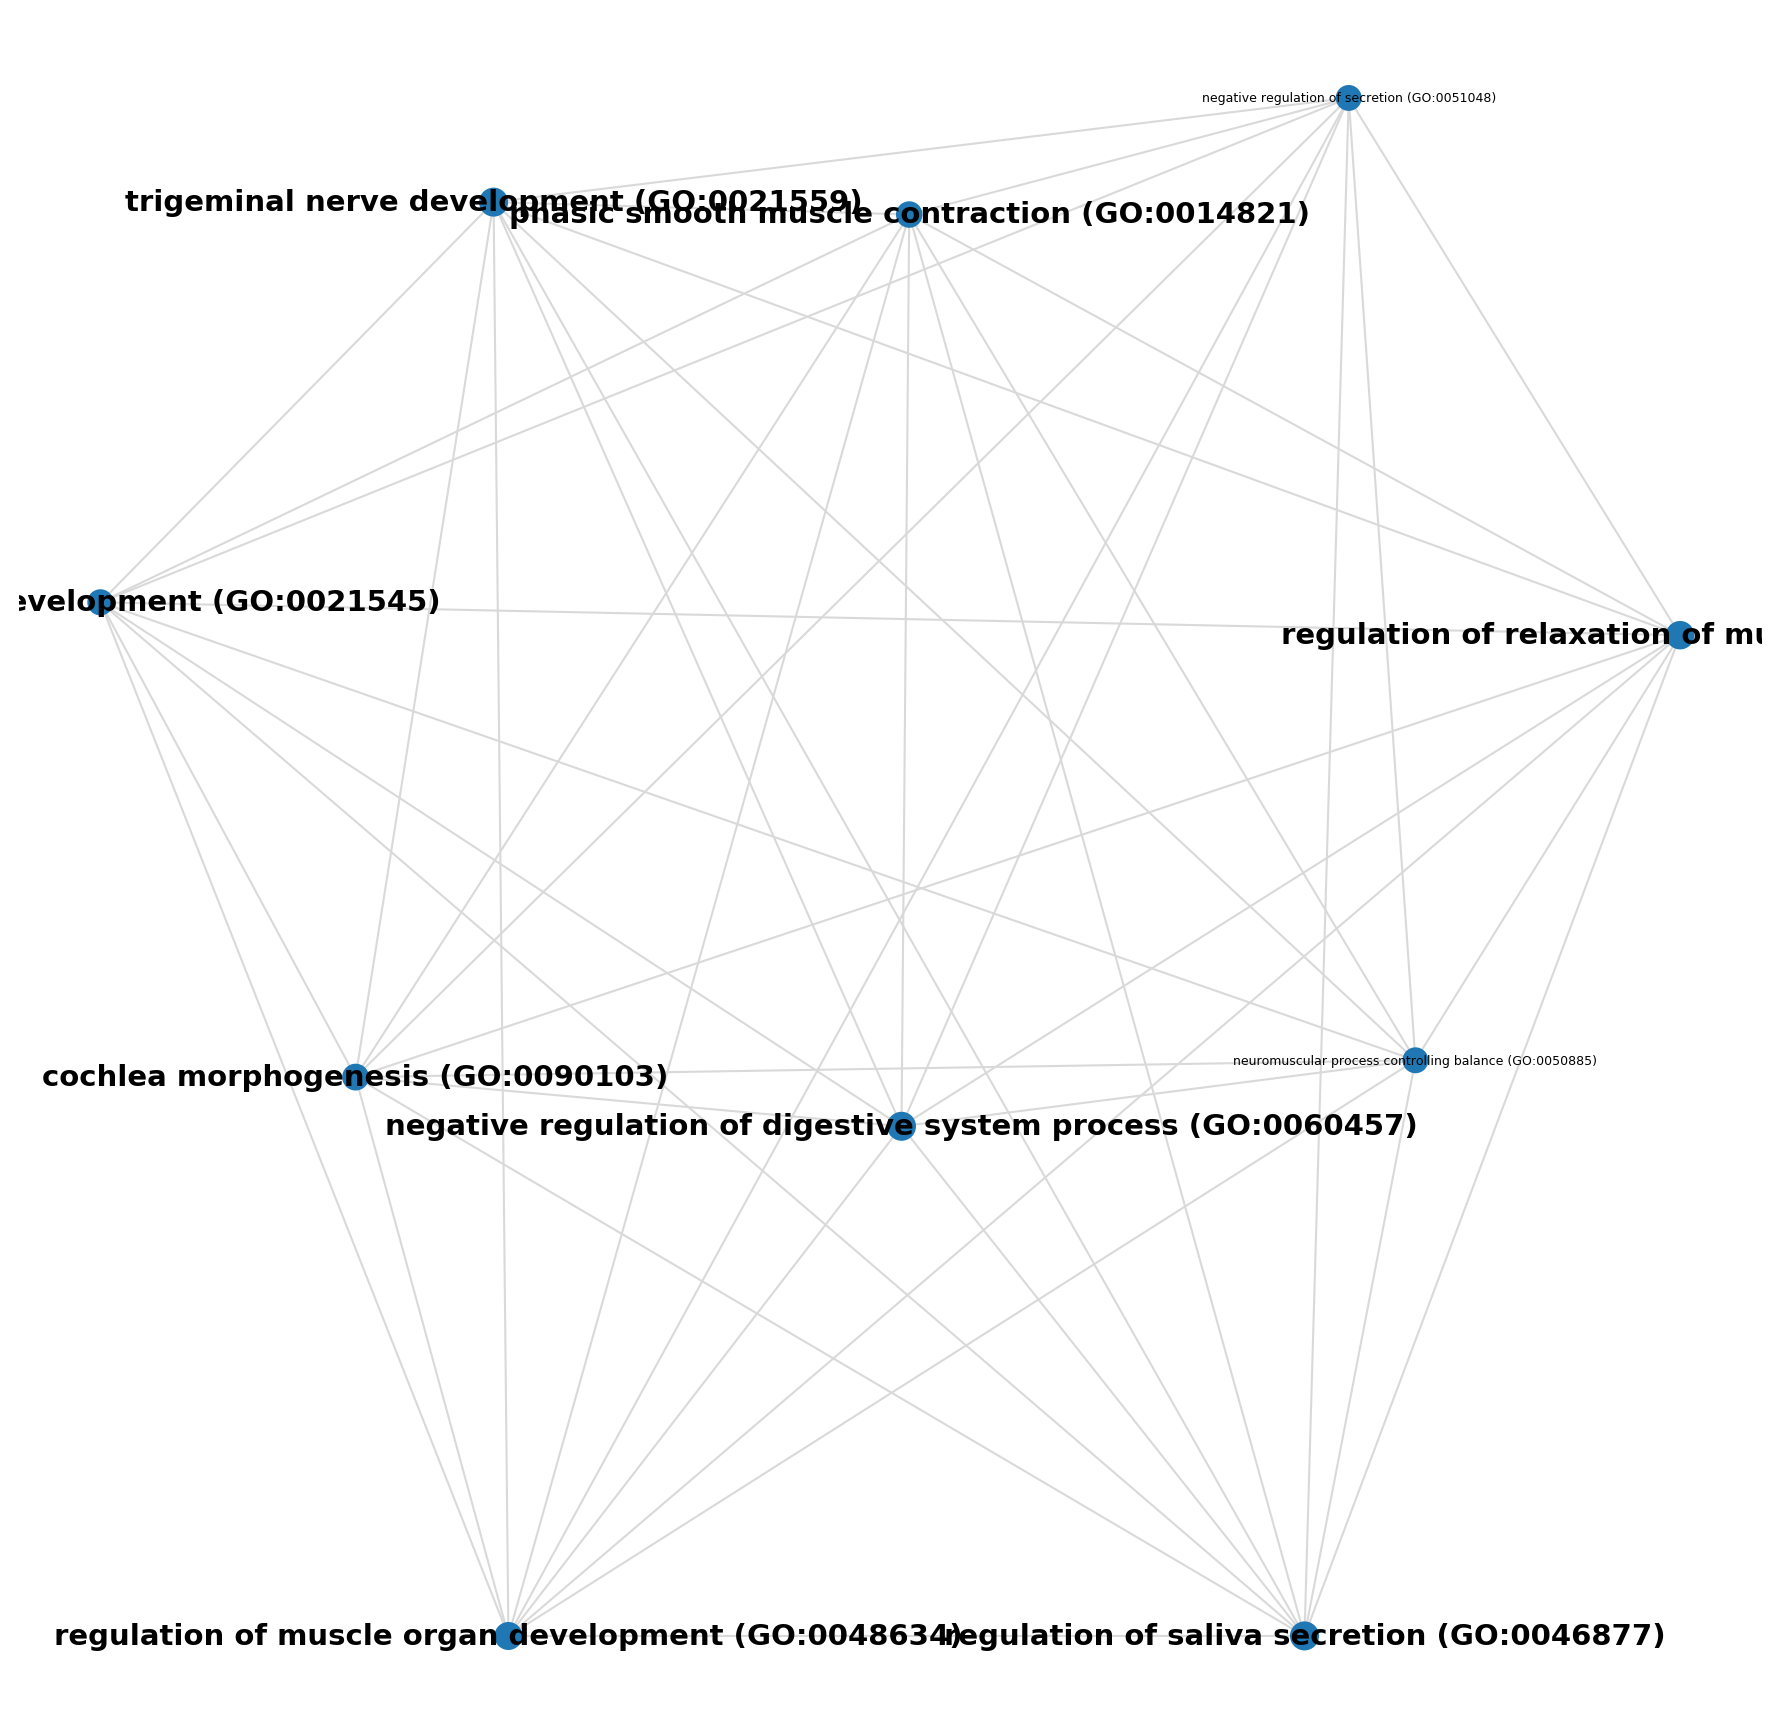

In [183]:
erl.draw_graph(G, spring=1000)

Text(0.5,1,'Genes for UP enhancers with TF mutations')

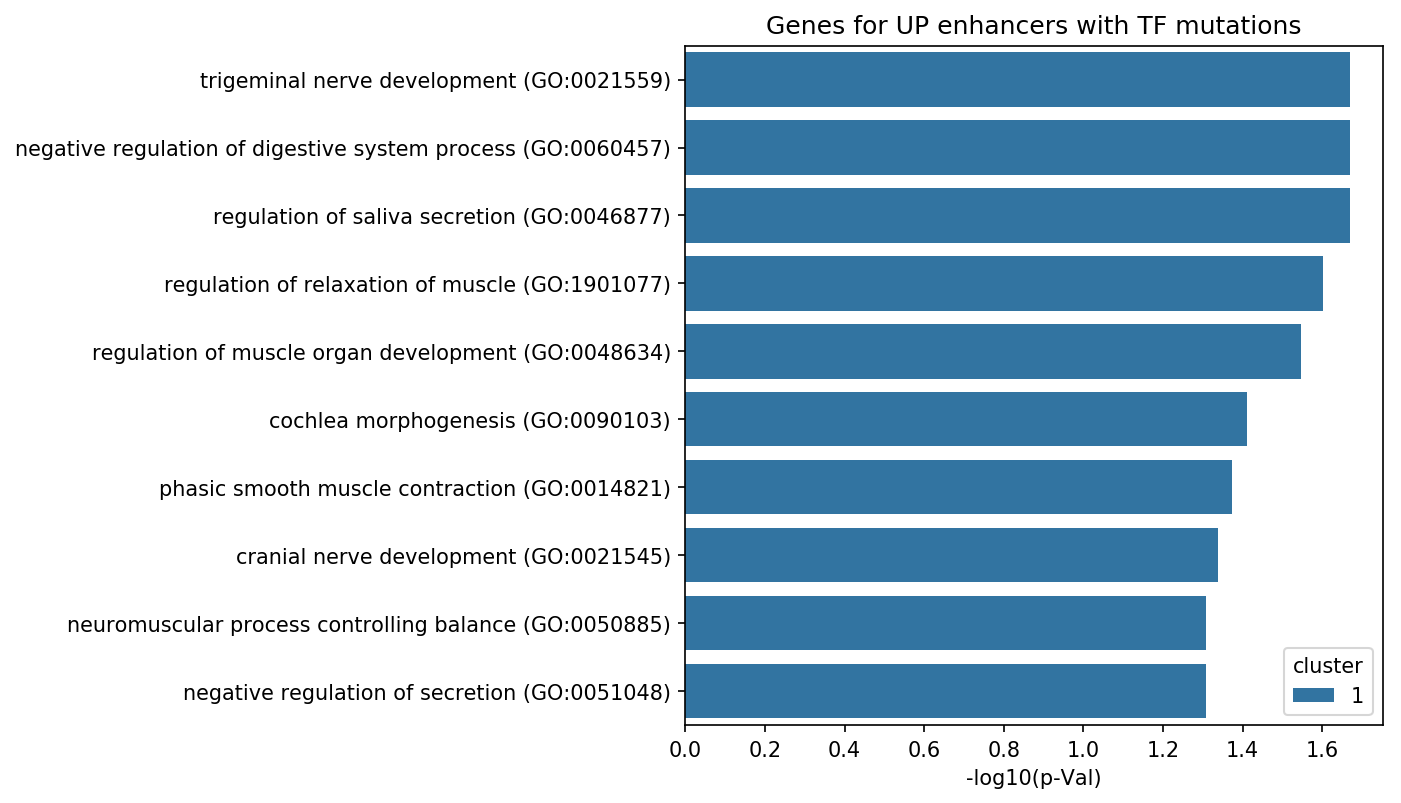

In [174]:
enr_genes_mut_tf_prom_c.sort_values('cluster', axis=0, inplace = True)
# --- Plot ---
# use consistent discrete palette
cm = 'tab20'

ds = enr_genes_mut_tf_prom_c.head(20)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('Genes for UP enhancers with TF mutations')

# RAG: Story ZERO 
# DN_RP(TLX3vsRAG)-->DN_Express(TLX3vsRAG)

In [ ]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

gl_dn = list(dn.index)

tmp=rn.scatter_n(expr[expr.index.isin(gl_dn)], A, B,classes=classes, n_top=18)

In [ ]:
## Two analysis possible

#dn_genes = gl_dn # genes with DN H3K27ac TLX3-vs-RAG 

dn_genes = list(tmp[1].index) # ONLY DNregulated genes from genes with DN H3K27ac TLX3-vs-RAG 

DN_genes = [x.upper() for x in dn_genes]

enr = erl.enrich_gs(DN_genes,gss, path_lib='../data/EnrichrLibs')

In [ ]:
# Make additional calculation on existing columns for visualization
enr.loc[:,'ass_genes_percnt'] = 100*enr.loc[:,'num_list']/enr.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_a = enr[(enr['p-Val']<0.05)] #&(enr['ass_genes_percnt']>8)

In [ ]:
## Cluster: this calculate and add cluster number column
#enr_a = erl.cluster(FIN_up_genes,enr_a)
cm = 'tab20'
G, enr_c, nt_b =erl.make_graph(DN_genes, 
                                   enr_a, 
                                   kappa=0.4)

In [ ]:
erl.draw_graph(G, 
                spring = 100,
                pval_prcnt=0.83,
                palette=cm)

In [ ]:
# --- Plot ---
# use consistent discrete palette

enr_c.sort_values('cluster', axis=0, inplace = True)
ds = enr_c.head(60)

f, ax = plt.subplots(figsize=(16, 15))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('DN genes regulated DN H3K27ac (TLX3/RAG) ')
